In [2]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

import time

import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# Set seed for reproducibility
import random

import torch
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
#plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
seed_value = 2042
random.seed(seed_value)
nltk.download('stopwords')


# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<Figure size 640x480 with 0 Axes>

In [3]:
df = pd.read_csv('cyberbullying_tweets.csv')
df = df[~df.duplicated()]
df = df.sample(frac=0.05, random_state=seed_value)
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2383 entries, 19005 to 5805
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          2383 non-null   object
 1   cyberbullying_type  2383 non-null   object
dtypes: object(2)
memory usage: 55.9+ KB


In [4]:
df.cyberbullying_type.value_counts()

,count
cyberbullying_type,
religion,428
ethnicity,408
not_cyberbullying,395
other_cyberbullying,388
gender,388
age,376


In [5]:
# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()

    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()

    return new_tweet

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())


def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

def strip_emoji(text):
     # Remove emojis (covers most common unicode emojis)
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def pipeline(tweet):
    tweet = strip_emoji(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())
    return tweet

In [6]:
import nltk
nltk.download('punkt_tab')
df['text_clean'] = [pipeline(tweet) for tweet in df['tweet_text']]
df.drop_duplicates("text_clean", inplace=True)
df.cyberbullying_type.value_counts()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,count
cyberbullying_type,
religion,424
ethnicity,384
age,372
gender,359
not_cyberbullying,315
other_cyberbullying,291


In [7]:
df = df[df["cyberbullying_type"]!="other_cyberbullying"]
bullying_classes = ["religion","age","ethnicity","gender","not bullying"]
df['tweet_len'] = [len(text.split()) for text in df.text_clean]
df = df[df['tweet_len'] < df['tweet_len'].quantile(0.995)]

<ipython-input-7-2ab0ca5469ed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet_len'] = [len(text.split()) for text in df.text_clean]


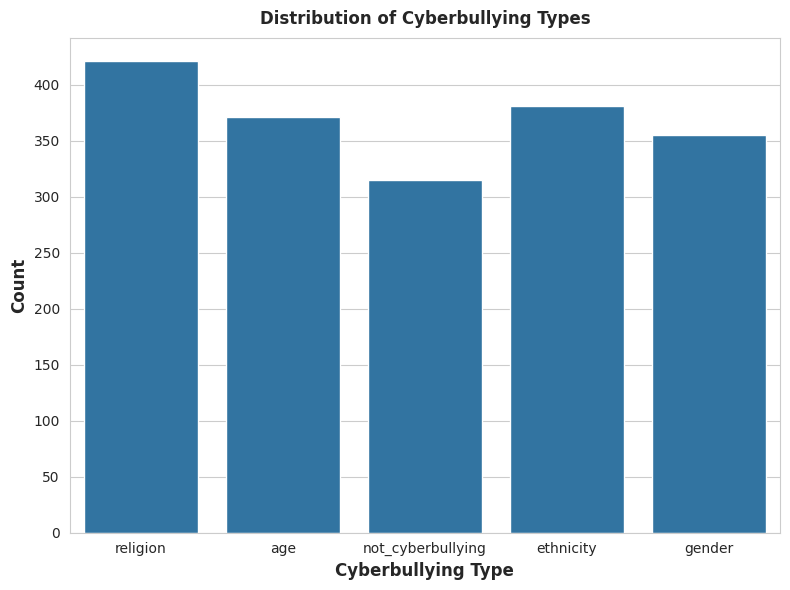

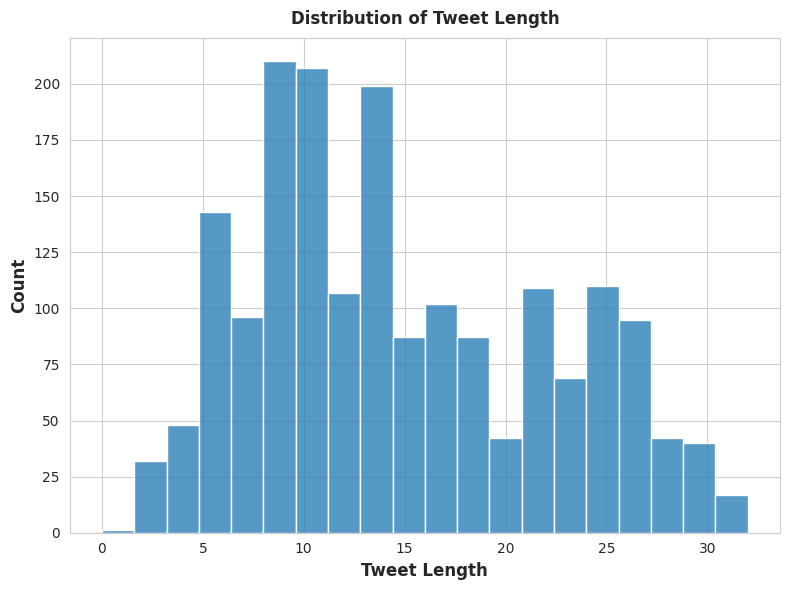

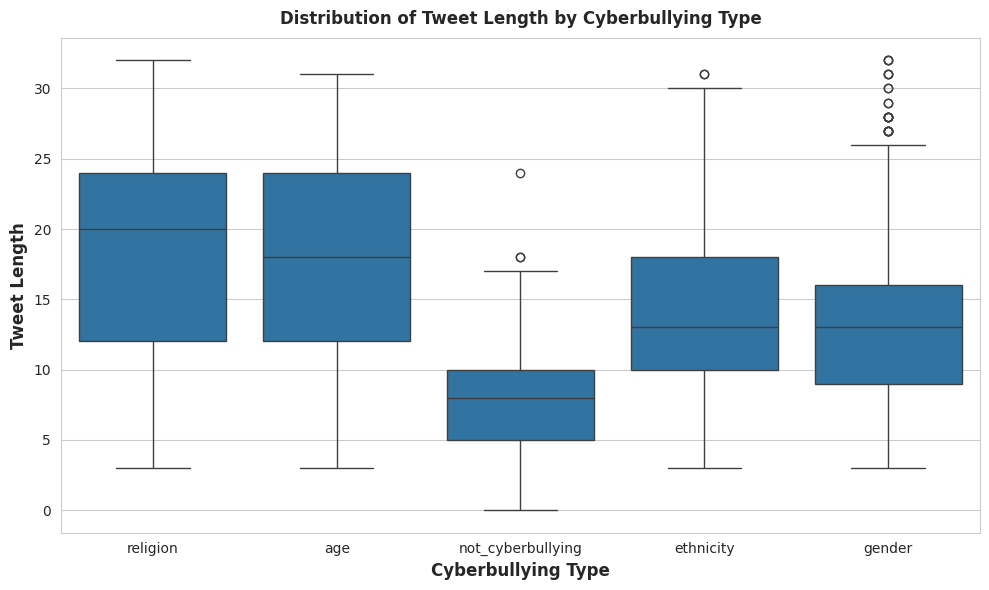

In [8]:
# Visualize the distribution of cyberbullying types
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='cyberbullying_type')
plt.title('Distribution of Cyberbullying Types')
plt.xlabel('Cyberbullying Type')
plt.ylabel('Count')
plt.show()

# Visualize the tweet length distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='tweet_len', bins=20)
plt.title('Distribution of Tweet Length')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.show()

# Visualize the distribution of tweet lengths for each cyberbullying type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='cyberbullying_type', y='tweet_len')
plt.title('Distribution of Tweet Length by Cyberbullying Type')
plt.xlabel('Cyberbullying Type')
plt.ylabel('Tweet Length')
plt.show()

In [9]:
df['cyberbullying_type'] = df['cyberbullying_type'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

X = df['text_clean']
y = df['cyberbullying_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

<ipython-input-9-cfeff82f8b76>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cyberbullying_type'] = df['cyberbullying_type'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 269],
       [  1, 269],
       [  2, 269],
       [  3, 269],
       [  4, 269]])

In [11]:
#BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,
            max_length=140,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [13]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
train_labels = torch.tensor(label_encoder.fit_transform(y_train_os))
val_labels = torch.tensor(label_encoder.transform(y_valid))
test_labels = torch.tensor(label_encoder.transform(y_test))


In [14]:
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler


batch_size = 32


# Training DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


# Validation DataLoader
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


# Test DataLoader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [15]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label_encoder.classes_)
)



config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from transformers import get_scheduler


# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 4
num_training_steps = len(train_dataloader) * epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


# Training Loop
for epoch in range(epochs):
   print(f"Epoch {epoch + 1}/{epochs}")
   model.train()
   total_loss = 0

   for batch in train_dataloader:
       b_input_ids, b_input_mask, b_labels = tuple(t for t in batch)

       model.zero_grad()
       outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
       loss = outputs.loss
       total_loss += loss.item()
       loss.backward()
       optimizer.step()
       lr_scheduler.step()

   print(f"Average training loss: {total_loss / len(train_dataloader):.4f}")

   # Validation after each epoch
   model.eval()
   val_preds, val_labels = [], []
   for batch in val_dataloader:
       b_input_ids, b_input_mask, b_labels = tuple(t for t in batch)

       with torch.no_grad():
           outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

       logits = outputs.logits
       val_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
       val_labels.extend(b_labels.cpu().numpy())

   accuracy = (torch.tensor(val_preds) == torch.tensor(val_labels)).sum().item() / len(val_labels)
   print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/4
Average training loss: 0.1149
Validation Accuracy: 0.8746
Epoch 2/4
Average training loss: 0.0708
Validation Accuracy: 0.8746
Epoch 3/4
Average training loss: 0.0292
Validation Accuracy: 0.8746
Epoch 4/4
Average training loss: 0.0219
Validation Accuracy: 0.8746


In [24]:
from sklearn.metrics import classification_report


model.eval()
test_preds, test_labels = [], []


for batch in test_dataloader:
   b_input_ids, b_input_mask, b_labels = tuple(t for t in batch)

   with torch.no_grad():
       outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

   logits = outputs.logits
   test_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
   test_labels.extend(b_labels.cpu().numpy())

   target_names = [str(cls) for cls in label_encoder.classes_]


print(classification_report(test_labels, test_preds, target_names=target_names))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95        85
           1       0.99      0.99      0.99        74
           2       0.99      0.96      0.97        76
           3       0.88      0.82      0.85        71
           4       0.76      0.83      0.79        63

    accuracy                           0.92       369
   macro avg       0.91      0.91      0.91       369
weighted avg       0.92      0.92      0.92       369



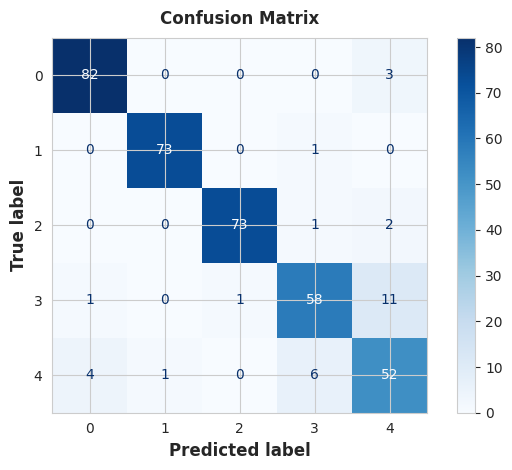

TypeError: object of type 'numpy.int64' has no len()

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Collect predictions and true labels
test_preds, test_labels = [], []

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t for t in batch)  # Adjust for CPU
    with torch.no_grad():
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    test_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
    test_labels.extend(b_labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Display class names from the LabelEncoder
class_names = label_encoder.classes_

# Create a Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Evaluate the model on test data
model.eval()
test_preds, test_labels = [], []

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t for t in batch)  # Adjust for CPU
    with torch.no_grad():
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    test_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
    test_labels.extend(b_labels.cpu().numpy())

# Print classification report
print(classification_report(test_labels, test_preds, target_names=label_encoder.classes_))

# Compute and display confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
